!pip install -r requirements.txt

# Intro
This sample notebook demonstrates the use of HANA Graph extensions of the "SAP HANA python client API for machine learning algorithms" (aka python client, HANA-ML).
In this notebook, we will download OpenStreetMap data from London, UK using osmnx. The road network consists of road segment and junctions. Two HANA dataframes will be created and a HANA Graph is defined on top of these two dataframes. A neighbors-induced sub-graph and a shortest path is calculated in the HANA database using its graph features. The resulting sub-graph and path is visualized using Kepler.gl.

You need to have you python environment set up properly (see..) and you need to have a SAP HANA Cloud database to connect to.

Download hana-ml python package:<br>
https://pypi.org/project/hana-ml/

Documentation:<br>
https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/2.0.05/en-US/index.html#

SAP HANA Trial:<br>
https://www.sap.com/cmp/td/sap-hana-cloud-trial.html

SAP HANA Cloud Graph reference:<br>
https://help.sap.com/viewer/11afa2e60a5f4192a381df30f94863f9/2020_03_QRC/en-US




# Setting the environment

In [10]:
# Popular tools
import pandas as pd                                     # main table handling in the notebook with numpy columns
import geopandas as gpd                                 # main geo visualization with extension of shapely columns
import osmnx as ox                                      # open source spatial intelligence (OSpINT)
from keplergl import KeplerGl                           # advanced geo visualization
# HANA-ML
import hana_ml
import hana_ml.graph.hana_graph as hana_graph

# Connecting to a SAP HANA database
You can register for the 30-days free trial of SAP HANA Cloud which you can use.
SAP HANA Cloud is a service on the SAP Cloud Platform. 

https://www.sap.com/cmp/td/sap-hana-cloud-trial.html

### Set the parameters used to connect to HANA Cloud

In [11]:
url = 'somehost.hana.trial-eu10.hanacloud.ondemand.com'
port = 443
user = 'USER_NAME'
pwd = 'Password'

### Connect to HANA using the hana_ml.ConnectionContext

In [12]:
cc = hana_ml.ConnectionContext(url, port, user, pwd)
print('HANA version: ' + cc.hana_version())
print('Current schema: ' + cc.get_current_schema())
schema = cc.get_current_schema()

HANA version: 4.00.000.00.1600157276 (fa/CE2020.36)
Current schema: GRAPH_USER


# Using osmnx to get OpenStreetMap and POI data
see https://github.com/gboeing/osmnx

### Set the parameters used to get OSM data
There are different network types like ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, or ‘all_private’.
osmnx can get the raod graph based on a place name, e.g. London, UK, or a gelocation. We use geolocation.

In [13]:
network_type='walk'
point = (51.507222, -0.1275)

### Get the OSM data via osmnx

In [14]:
G = ox.graph_from_point(point, dist=500, network_type=network_type, simplify=False)

### Extracting the edges(=street segments) and vertices(=junctions)

In [15]:
vertices_gdf, edges_gdf = ox.graph_to_gdfs(G)

### Plot the network

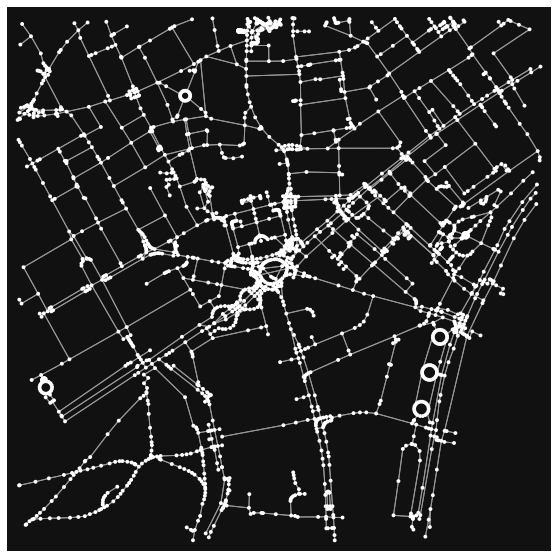

In [16]:
fig, ax = ox.plot_graph(G, figsize=(10, 10))

### Inspect the vertices and edges
The vertices contain a geometry, i.e. the geolocation of the junction

In [17]:
vertices_gdf.head(5)

,y,x,osmid,highway,ref,geometry
6277660685,51.511654,-0.121137,6277660685,give_way,NaN,POINT (-0.12114 51.51165)
1174970393,51.508500,-0.122470,1174970393,NaN,NaN,POINT (-0.12247 51.50850)
6277660702,51.511203,-0.122227,6277660702,give_way,NaN,POINT (-0.12223 51.51120)
2620416030,51.506139,-0.124369,2620416030,NaN,NaN,POINT (-0.12437 51.50614)
2620416036,51.506200,-0.124218,2620416036,NaN,NaN,POINT (-0.12422 51.50620)


The edges contain a linestring and two vertices u and v which are the source and target of the edges

In [18]:
edges_gdf[['osmid', 'name', 'length', 'u', 'v', 'geometry']].head(3)

,osmid,name,length,u,v,geometry
0,585735070,Burleigh Street,4.829,6277660685,1614846702,"LINESTRING (-0.12114 51.51165, -0.12120 51.51167)"
1,585735070,Burleigh Street,17.511,6277660685,2831321470,"LINESTRING (-0.12114 51.51165, -0.12091 51.51159)"
2,4253952,Savoy Place,4.454,1174970393,25474753,"LINESTRING (-0.12247 51.50850, -0.12242 51.50852)"


# Store the data in the database
We use the create_dataframe_from_pandas method to push the data into tables. First we create a unique key for the edges. This is required later when we define a HANA Graph Workspace.

In [19]:
edges_gdf['ID'] = edges_gdf['u'].astype(str) + '-' + edges_gdf['v'].astype(str) + '-' + edges_gdf['key'].astype(str)

# store data in HANA
edges_hdf = hana_ml.dataframe.create_dataframe_from_pandas(
    connection_context=cc,
    pandas_df=edges_gdf,
    schema=schema, table_name="LONDON_DEMO_EDGES", primary_key='ID', not_nulls=['u', 'v'],
    geo_cols={('geometry'): 4326}, 
    replace=False, force=True, drop_exist_tab=True, allow_bigint=True
)

vertices_hdf = hana_ml.dataframe.create_dataframe_from_pandas(
    connection_context=cc,
    pandas_df=vertices_gdf, 
    schema=schema, table_name="LONDON_DEMO_VERTICES", primary_key='osmid',
    geo_cols={('geometry'): 4326}, 
    replace=False, force=True, drop_exist_tab=True, allow_bigint=True
)

# Create a HANA Graph
Next we create a HANA graph from the two HANA dataframes. In the database, a so-called GRAPH WORKSPACE is created.

In [20]:
G_hana = hana_graph.create_hana_graph_from_vertex_and_edge_frames(
    connection_context=cc, 
    vertices_hdf=vertices_hdf, 
    edges_hdf=edges_hdf,
    schema=schema, workspace_name='LONDON_DEMO_GRAPH',
    vertex_key_column='osmid', edge_source_column='u', edge_target_column='v',
    edge_key_column='ID'
)

# Using basic functions
You can discover the LONDON_DEMO_GRAPH we just created.

In [21]:
gws = hana_ml.graph.hana_graph.discover_graph_workspaces(connection_context=cc)
gws[['SCHEMA_NAME','WORKSPACE_NAME', 'EDGE_TABLE_NAME', 'VERTEX_TABLE_NAME']]

,SCHEMA_NAME,WORKSPACE_NAME,EDGE_TABLE_NAME,VERTEX_TABLE_NAME
0,ASFINAG_RR,GRAPH_ROAD_WITH_TRAFFIC_JAM,EDGE_INTERVALS_TRAFIC_JAM,MAUTNODES
1,DAT260,BIKE_GRAPH,LONDON_EDGES,LONDON_VERTICES
2,DAT260,LONDON_GRAPH,LONDON_EDGES,LONDON_VERTICES
3,DAT260,TUBE_GRAPH,LONDON_TUBE_CONNECTIONS,LONDON_TUBE_STATIONS
4,GDELT,ACTOR_GRAPH,ACTOR_EDGES,ACTOR_NODES
5,GDELT,GKG_GRAPH,GKG_EDGES,GKG_NODES
6,GRAPHSCRIPT,GRAPHWS,EDGES,VERTICES
7,GRAPH_USER,LONDON_DEMO_GRAPH,LONDON_DEMO_EDGES_VIEW,LONDON_DEMO_VERTICES_VIEW
8,GRAPH_USER,LONDON_GRAPH,LONDON_EDGES_VIEW,LONDON_VERTICES_VIEW
9,GRAPH_USER,RAILROADS_DEMO,RAILROADS_VIEW,VERTICES_VIEW


The hana_graph object has a *vertices()* and *edges()* function to access the data, optionally using the key.

Vertices can be retrieved
<li>using the vertex_key, e.g. vertices(vertex_key = 26630785)
<li>finding source/target of an edge, e.g. target(edge_key = '26630785-3557235449-0')

In [22]:
vertex_key = 26630785
G_hana.vertices(vertex_key = vertex_key)

,y,x,osmid,highway,ref,geometry_GEO
0,51.505509,-0.13431,26630785,None,None,POINT (-0.1343102 51.5055088)


Edges can be retrieved 
<li>using the edge_key, e.g. edges(edge_key = '26630785-3557235449-0')
<li>finding incident edges of a vertex, edges(vertex_key, direction=['OUTGOING', 'INCOMING', 'ANY'])

In [23]:
G_hana.edges(vertex_key = vertex_key, direction = 'ANY')[['ID', 'name', 'length', 'u', 'v', 'geometry_GEO']]

,ID,name,length,u,v,geometry_GEO
0,26630785-3557235449-0,Carlton Gardens,20.319,26630785,3557235449,"LINESTRING (-0.1343102 51.5055088, -0.1340504 ..."
1,3557235449-26630785-0,Carlton Gardens,20.319,3557235449,26630785,"LINESTRING (-0.1340504 51.5055939, -0.1343102 ..."


# Using the *neighbors* function
The neighbors function returns vertices that can be reached within a certain number of hops (min_depth, max_dapth), taversing edges in the defined direction - INCOMING, OUTGOING, ANY.

In [24]:
nei = G_hana.neighbors(start_vertex=vertex_key, min_depth=0 , max_depth=30, direction='ANY')
nei

,osmid
0,26630785
1,3557235449
2,3557235398
3,3557235440
4,25607361
...,...
818,2390039153
819,2726851379
820,2390005218
821,2726861251


If the optional parameters include_edges is True, the neighbors() function a vertex induced subgraph, or "ego-graph".

In [25]:
nei_graph = G_hana.neighbors(start_vertex=vertex_key, min_depth=0 , max_depth=30, direction='ANY', include_edges=True)
nei_graph.edges()

,u,v,ID
0,26630785,3557235449,26630785-3557235449-0
1,3557235449,26630785,3557235449-26630785-0
2,3557235449,3557235398,3557235449-3557235398-0
3,3557235449,3557235440,3557235449-3557235440-0
4,3557235398,3557235449,3557235398-3557235449-0
...,...,...,...
1847,2726851379,2726851377,2726851379-2726851377-0
1848,2726851379,2726861296,2726851379-2726861296-0
1849,2390005218,2390005221,2390005218-2390005221-0
1850,2726861251,2726861249,2726861251-2726861249-0


# Using the *shortest_path* function
The shortest path function calculates the hop-distance shortest path between source and target vertex, or if a weight column is specified, the least cost path. The underlying HANA built-in algorithm is even more powerful, see [the documentation](https://help.sap.com/viewer/11afa2e60a5f4192a381df30f94863f9/2020_03_QRC/en-US/3b0a971b129c446c9e40a797bdb29c2b.html) or [some examples](https://github.com/SAP-samples/hana-graph-examples/tree/main/GRAPH_PROCEDURE_EXAMPLES/BUILTIN_FUNCTIONS_ALGORITHMS).

In [26]:
shortest_path = G_hana.shortest_path(source=vertex_key, target=25544127, direction='ANY', weight='length')
shortest_path.edges()

,u,v,ID,EDGE_ORDER
0,26630785,3557235449,26630785-3557235449-0,1
1,3557235449,3557235398,3557235449-3557235398-0,2
2,3557235398,25607361,3557235398-25607361-0,3
3,25607361,25607360,25607361-25607360-0,4
4,25607360,454543312,25607360-454543312-0,5
...,...,...,...,...
62,6173783039,1678452769,6173783039-1678452769-0,63
63,1678452776,6173783039,1678452776-6173783039-0,64
64,1678452778,1678452776,1678452778-1678452776-0,65
65,25544130,1678452778,25544130-1678452778-0,66


# Plot the shortest path on a map
First we will add the geometry data to the path so we can put it on a map.

In [27]:
shortest_path_hdf = G_hana.edges_hdf.filter(" ID IN ('" + shortest_path.edges().ID.astype(str).str.cat(sep="','") + "') ")
nei_graph_hdf = G_hana.edges_hdf.filter(" ID IN ('" + nei_graph.edges().ID.astype(str).str.cat(sep="','") + "') ")

We use Kepler.gl to visualize the street network and the path.

In [28]:
# assign london_config
%run london_config.py

map = KeplerGl(height=800, width=1200)
map.config = london_config
map.add_data(gpd.GeoDataFrame(shortest_path_hdf.collect(), geometry='geometry_GEO'), name='shortest_path')
map.add_data(gpd.GeoDataFrame(nei_graph_hdf.collect(), geometry='geometry_GEO'), name='neighbors')
map.add_data(gpd.GeoDataFrame(edges_hdf.collect(), geometry='geometry_GEO'), name='graph')
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\d003411\AppData\Local\Continuum\anaconda3\envs\env_gs\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
C:\Users\d003411\AppData\Local\Continuum\anaconda3\envs\env_gs\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
C:\Users\d003411\AppData\Local\Continuum\anaconda3\envs\env_gs\lib\site-packages\geopandas\geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['POIs'], 'id': 'uwrnb7rov', …